In [1]:
%matplotlib widget 
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import math
import h5py

In [2]:

def histogram_cic_1d(q1, w, nbins, bins_start, bins_end):
    """
    Return an 1D histogram of the values in `q1` weighted by `w`,
    consisting of `nbins` evenly-spaced bins between `bins_start`
    and `bins_end`. Contribution to each bins is determined by the
    CIC weighting scheme (i.e. linear weights).
    Source: https://github.com/openPMD/openPMD-viewer/blob/dev/openpmd_viewer/openpmd_timeseries/utilities.py
    """
    # Define various scalars
    bin_spacing = (bins_end - bins_start) / nbins
    inv_spacing = 1. / bin_spacing
    n_ptcl = len(w)

    # Allocate array for histogrammed data
    hist_data = np.zeros(nbins, dtype=np.float64)

    # Go through particle array and bin the data
    for i in range(n_ptcl):
        # Calculate the index of lower bin to which this particle contributes
        q1_cell = (q1[i] - bins_start) * inv_spacing
        i_low_bin = int(math.floor(q1_cell))
        # Calculate corresponding CIC shape and deposit the weight
        S_low = 1. - (q1_cell - i_low_bin)
        if (i_low_bin >= 0) and (i_low_bin < nbins):
            hist_data[i_low_bin] += w[i] * S_low
        if (i_low_bin + 1 >= 0) and (i_low_bin + 1 < nbins):
            hist_data[i_low_bin + 1] += w[i] * (1. - S_low)

    return (hist_data)



def histogram_cic_2d(q1, q2, w,
                     nbins_1, bins_start_1, bins_end_1,
                     nbins_2, bins_start_2, bins_end_2):
    """
    Return an 2D histogram of the values in `q1` and `q2` weighted by `w`,
    consisting of `nbins_1` bins in the first dimension and `nbins_2` bins
    in the second dimension.
    Contribution to each bins is determined by the
    CIC weighting scheme (i.e. linear weights).
    Source:https://github.com/openPMD/openPMD-viewer/blob/dev/openpmd_viewer/openpmd_timeseries/utilities.py
    """
    # Define various scalars
    bin_spacing_1 = (bins_end_1 - bins_start_1) / nbins_1
    inv_spacing_1 = 1. / bin_spacing_1
    bin_spacing_2 = (bins_end_2 - bins_start_2) / nbins_2
    inv_spacing_2 = 1. / bin_spacing_2
    n_ptcl = len(w)

    # Allocate array for histogrammed data
    hist_data = np.zeros((nbins_1, nbins_2), dtype=np.float64)

    # Go through particle array and bin the data
    for i in range(n_ptcl):

        # Calculate the index of lower bin to which this particle contributes
        q1_cell = (q1[i] - bins_start_1) * inv_spacing_1
        q2_cell = (q2[i] - bins_start_2) * inv_spacing_2
        i1_low_bin = int(math.floor(q1_cell))
        i2_low_bin = int(math.floor(q2_cell))

        # Calculate corresponding CIC shape and deposit the weight
        S1_low = 1. - (q1_cell - i1_low_bin)
        S2_low = 1. - (q2_cell - i2_low_bin)
        if (i1_low_bin >= 0) and (i1_low_bin < nbins_1):
            if (i2_low_bin >= 0) and (i2_low_bin < nbins_2):
                hist_data[i1_low_bin, i2_low_bin] += w[i] * S1_low * S2_low
            if (i2_low_bin + 1 >= 0) and (i2_low_bin + 1 < nbins_2):
                hist_data[i1_low_bin, i2_low_bin + 1] += w[i] * S1_low * (1. - S2_low)
        if (i1_low_bin + 1 >= 0) and (i1_low_bin + 1 < nbins_1):
            if (i2_low_bin >= 0) and (i2_low_bin < nbins_2):
                hist_data[i1_low_bin + 1, i2_low_bin] += w[i] * (1. - S1_low) * S2_low
            if (i2_low_bin + 1 >= 0) and (i2_low_bin + 1 < nbins_2):
                hist_data[i1_low_bin + 1, i2_low_bin + 1] += w[i] * (1. - S1_low) * (1. - S2_low)

    return (hist_data)


## Load CSRtrack Data

In [3]:
data = np.loadtxt(r'G:\My Drive\Stanford\research\FEL\CSR\CSRtrack\benchmark_facet_2024\out\dipole_0011.fmt3')
z = data[1:, 4]
delta = data[1:, 5]
Q = data[1:, 6]
x = data[1:, 0]
xp = data[1:, 1]
t = data[0,0]
gam0 = data[0,1]
fz = data[1:, 7]
fx = data[1:, 8]

print("Plotting at z=", t)

x -= np.mean(x)
z -= np.mean(z)
n = z.shape[0]
sig_x = np.std(x)
sig_z = np.std(z)
print('sig_x = ', sig_x )
print('sig_z = ', sig_z)

Plotting at z= 1.0629883480282
sig_x =  9.286854271918206e-05
sig_z =  3.4110206140390703e-06


## Load pyDFCSR data

In [5]:
 
wake_filename = r"..\output\facet_obed-2024-05-27T09_30_01-07_00-wakes.h5"
step = 'step_23'
with h5py.File(wake_filename, "r") as f:
    print("t =  {}".format(f[step].attrs['position']))
    print("ebeam energy {}".format(f[step].attrs['beam_energy']))
    dE_dct = np.array(f[step]['longitudinal']['dE_dct'])
    unit = f[step]['longitudinal'].attrs['unit']

    x_grids = np.array(f[step]['longitudinal']['x_grids']).reshape(dE_dct.shape)
    z_grids = np.array(f[step]['longitudinal']['z_grids']).reshape(dE_dct.shape)

    xkicks = np.array(f[step]['transverse']['xkicks'])



t =  1.1500000000000004
ebeam energy 9856000000.0


In [7]:
particle_filename = r"..\output\facet_obed-2024-05-27T09_30_01-07_00-particles.h5"
with h5py.File(particle_filename, "r") as f:
    x2 = np.array(f[step]['particles']['x'])
    xp2 = np.array(f[step]['particles']['xp'])
    y2 = np.array(f[step]['particles']['y'])
    yp2 = np.array(f[step]['particles']['z'])
    z2 = np.array(f[step]['particles']['z'])
    delta2 = np.array(f[step]['particles']['delta'])

In [9]:
particle_filename = r"..\output\facet_obed-2024-05-27T09_30_01-07_00-statistics.h5"
with h5py.File(particle_filename, "r") as f:
    print(f.keys())
    t2 = np.array(f['step_positions'])
    alphaX2 = np.array(f['alphaX_beam'])
    betaX2 = np.array(f['betaX_beam'])
    gemitX2 = np.array(f['gemitX'])
    sigmaX2 = np.array(f['sigX'])
    sigmaZ2 = np.array(f['sigZ'])

<KeysViewHDF5 ['Cx', 'Cxp', 'R51', 'R52', 'R56', 'alphaX', 'alphaX_beam', 'alphaX_minus_dispersion', 'betaX', 'betaX_beam', 'betaX_minus_dispersion', 'coords', 'etaX', 'etaXp', 'gemitX', 'gemitX_minus_dispersion', 'n_vec', 'sigE', 'sigX', 'sigZ', 'slope', 'step_positions', 'tau_vec']>


## Plot the wakes

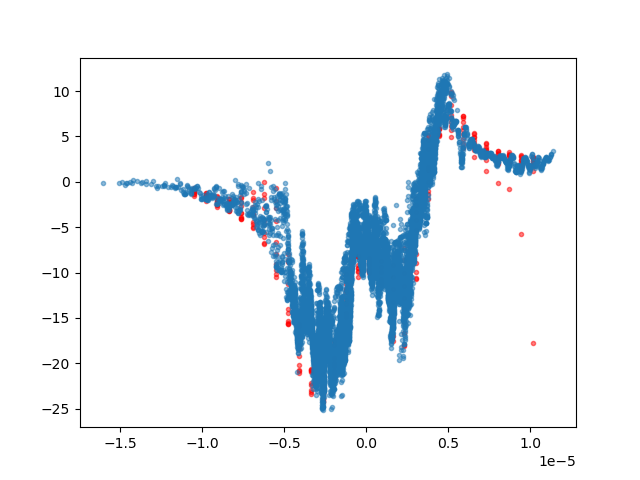

In [10]:
plt.figure()
plt.plot(z_grids, dE_dct, '.', alpha = 0.5, color = 'r')
plt.plot(z, fz/1e6, '.',alpha = 0.5)
plt.show()

In [11]:
nx = 10
nz = 30
xlim = 3
zlim = 3


meanx = np.mean(x)
meanz = np.mean(z)
x -= meanx
z -= meanz
n = z.shape[0]
sig_x = np.std(x)
sig_z = np.std(z)

xrange = np.linspace(meanx-xlim*sig_x, meanx+xlim*sig_x, nx)
zrange = np.linspace(meanz-zlim*sig_z, meanz+zlim*sig_z, nz)
xmesh, ymesh = np.meshgrid(xrange, zrange, indexing = 'ij')
fz_count = histogram_cic_2d(q1 = x, q2 = z, w = fz/1e6,
                     nbins_1 = nx, bins_start_1 = meanx-xlim*sig_x, bins_end_1 = meanx + xlim*sig_x,
                     nbins_2 = nz, bins_start_2 = meanz-zlim*sig_z, bins_end_2 = meanz + zlim*sig_z)
density_count = histogram_cic_2d(q1 = x, q2 = z, w = np.ones(z.shape),
                     nbins_1 = nx, bins_start_1 = meanx-xlim*sig_x, bins_end_1 = meanx + xlim*sig_x,
                     nbins_2 = nz, bins_start_2 = meanz-zlim*sig_z, bins_end_2 = meanz+ zlim*sig_z)
fz_bin = fz_count/density_count
#plot_surface(xrange, zrange, fz_bin)

C:\Users\yingb\AppData\Local\Temp\ipykernel_45696\978577780.py:24: RuntimeWarning: invalid value encountered in divide
  fz_bin = fz_count/density_count


C:\Users\yingb\AppData\Local\Temp\ipykernel_45696\2735727288.py:27: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = 10


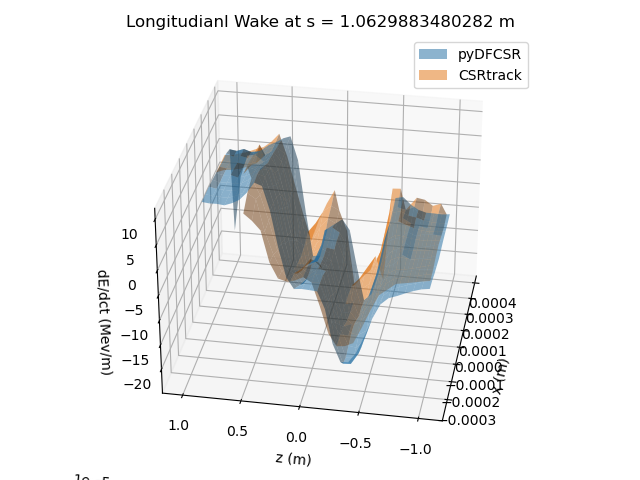

In [12]:
X, Y = x_grids, z_grids
Z = dE_dct

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surf1 = ax.plot_surface(X, Y, Z, color ='C0', alpha = 0.5, label = 'pyDFCSR')

surf1._edgecolors2d = surf1._edgecolor3d
surf1._facecolors2d = surf1._facecolor3d
 
ax.set_title('3D Surface plot')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
#ax.set_ylim([-0.4e-5, 1e-5])
#ax.scatter(x, z, fz/1e6, color='red', s=2)
surf2 = ax.plot_surface(xmesh, ymesh, fz_bin, color ='C1', alpha = 0.5, label = 'CSRtrack')
ax.set_xlabel('x (m)')
ax.set_ylabel('z (m)')
ax.set_zlabel('dE/dct (Mev/m)')
ax.set_title('Longitudianl Wake at s = {} m'.format(t))

surf2._edgecolors2d = surf2._edgecolor3d
surf2._facecolors2d = surf2._facecolor3d

ax.azim = 190
ax.dist = 10
ax.elev = 30

ax.legend()
plt.tight_layout()
plt.show()


C:\Users\yingb\AppData\Local\Temp\ipykernel_45696\4055751515.py:9: RuntimeWarning: invalid value encountered in divide
  fx_bin = fx_count/density_count
C:\Users\yingb\AppData\Local\Temp\ipykernel_45696\4055751515.py:32: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = 10


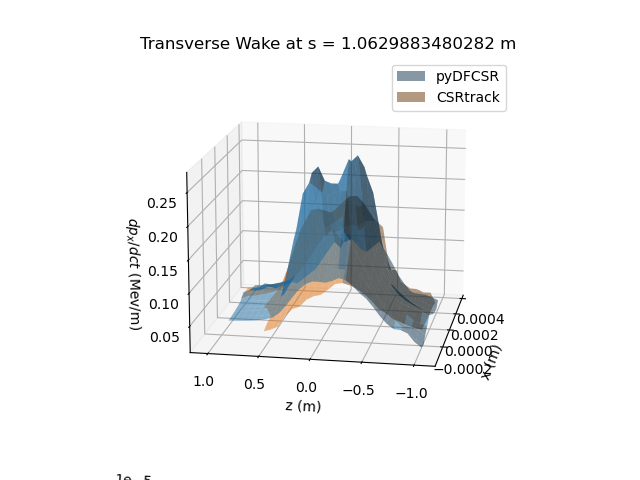

In [13]:
xrange = np.linspace(meanx-3*sig_x, meanx+3*sig_x, nx)
zrange = np.linspace(meanz-3*sig_z, meanz+3*sig_z, nz)
fx_count = histogram_cic_2d(q1 = x, q2 = z, w = fx/1e6,
                     nbins_1 = nx, bins_start_1 = meanx-3*sig_x, bins_end_1 = meanx + 3*sig_x,
                     nbins_2 = nz, bins_start_2 = meanz-3*sig_z, bins_end_2 = meanz + 3*sig_z)
density_count = histogram_cic_2d(q1 = x, q2 = z, w = np.ones(z.shape),
                     nbins_1 = nx, bins_start_1 = meanx-3*sig_x, bins_end_1 = meanx + 3*sig_x,
                     nbins_2 = nz, bins_start_2 = meanz-3*sig_z, bins_end_2 = meanz+ 3*sig_z)
fx_bin = fx_count/density_count

X, Y = x_grids, z_grids
Z = xkicks

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surf1 = ax.plot_surface(X, Y, Z, color ='C0', alpha = 0.5, label = 'pyDFCSR')

surf1._edgecolors2d = surf1._edgecolor3d
surf1._facecolors2d = surf1._facecolor3d
 
ax.set_xlabel('x (m)')
ax.set_ylabel('z (m)')
ax.set_zlabel('$dp_x/dct$ (Mev/m)')
ax.set_title('Transverse Wake at s = {} m'.format(t))
#ax.scatter(x, z, fx/1e6, color='red', s=1)
surf2 = ax.plot_surface(xmesh, ymesh, fx_bin, color ='C1', alpha = 0.5, label = 'CSRtrack')

surf2._edgecolors2d = surf2._edgecolor3d
surf2._facecolors2d = surf2._facecolor3d

ax.azim = 190
ax.dist = 10
ax.elev = 15

ax.legend()

plt.show()

## Plot particles

Text(0, 0.5, 'z(m )')

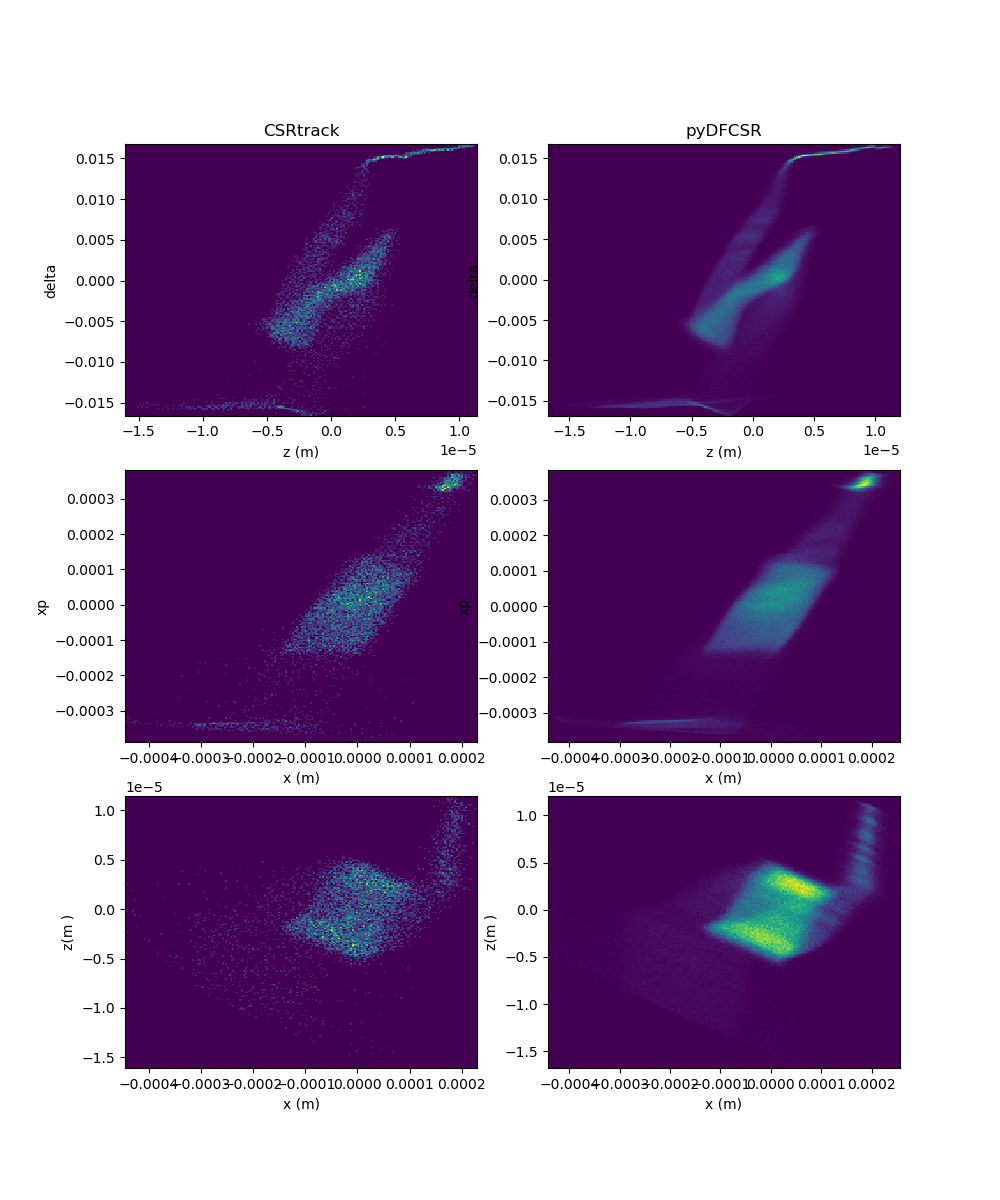

In [14]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize = (10, 12))
axes[0, 0].set_title('CSRtrack')
axes[0, 1].set_title('pyDFCSR')
ax1 = axes[0,0]
ax2 = axes[0,1]
surf = ax1.hist2d(z, delta, bins = 200)
surf2 = ax2.hist2d(z2, delta2, bins = 200)
ax1.set_xlabel('z (m)')
ax1.set_ylabel('delta')
ax2.set_xlabel('z (m)')
ax2.set_ylabel('delta')

ax1 = axes[1,0]
ax2 = axes[1,1]
surf = ax1.hist2d(x, xp, bins = 200)
surf2 = ax2.hist2d(x2, xp2, bins = 200)
ax1.set_xlabel('x (m)')
ax1.set_ylabel('xp')
ax2.set_xlabel('x (m)')
ax2.set_ylabel('xp')

ax1 = axes[2,0]
ax2 = axes[2,1]
surf = ax1.hist2d(x, z, bins = 200)
surf2 = ax2.hist2d(x2, z2, bins = 200)
ax1.set_xlabel('x (m)')
ax1.set_ylabel('z(m )')
ax2.set_xlabel('x (m)')
ax2.set_ylabel('z(m )')

## Plot Statistics

In [15]:
#slice emittance
def get_slice_emittance(z, x, xp, nbins = 100):
    zmean = np.mean(z)
    sigma_z = np.std(z)
    zrange = np.linspace(zmean - 3*sigma_z,zmean + 3*sigma_z, nbins + 1)
    emitX = np.zeros((nbins,))
    for k in range(nbins):
        zmin = zrange[k]
        zmax = zrange[k + 1]
        ind = (z>=zmin) &(z < zmax)
        x_slice = x[ind]
        xp_slice = xp[ind]
        
        emitX_slice = np.sqrt(np.mean(x_slice**2)*np.mean(xp_slice**2) - np.mean(x_slice*xp_slice)**2)
        emitX[k] = emitX_slice
    
    zpos = (zrange[:-1] + zrange[1:])/2
    return zpos, emitX
        

In [16]:
zpos1, emitX1 = get_slice_emittance(z, x, xp, nbins = 50)
zpos2, emitX2 = get_slice_emittance(z2, x2, xp2, nbins = 50)

Text(0, 0.5, 'emitX (m)')

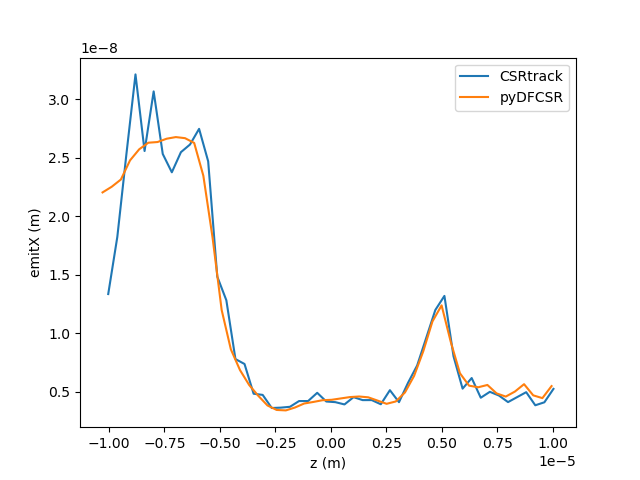

In [17]:
plt.figure()
plt.plot(zpos1, emitX1, label = 'CSRtrack')
plt.plot(zpos2, emitX2, label = 'pyDFCSR')
plt.legend()
plt.xlabel('z (m)')
plt.ylabel('emitX (m)')

## load all CSRtrack files

In [18]:
N = 12
folder =r"G:\My Drive\Stanford\research\FEL\CSR\CSRtrack\benchmark_facet_2024\out"
CSRtrack_stats = {'t': np.zeros((N,)), 'sigma_x': np.zeros((N,)), 'sigma_z': np.zeros((N,)), 
                  'emitX': np.zeros((N,)), 'norm_emitX': np.zeros((N,)),
                  'betaX': np.zeros((N,)), 'alphaX': np.zeros((N,))}
for k in range(N):
    filename = 'dipole_{:04d}.fmt3'.format(k + 1)
    data = np.loadtxt(folder + '/' + filename)
    z = data[1:, 4]
    delta = data[1:, 5]

    x = data[1:, 0]
    xp = data[1:, 1]

    t = data[0,0]
    gam0 = data[0,1]

    print("Loading at z=", t)


    sigma_x = np.std(x)
    sigma_z = np.std(z)
    emitX = np.sqrt(np.mean(x**2)*np.mean(xp**2) - np.mean(x*xp)**2)
    norm_emitX = gam0*emitX
    betaX = sigma_x**2/emitX
    alphaX = -np.mean(x*xp)/emitX
    
    CSRtrack_stats['t'][k] = t
    CSRtrack_stats['sigma_x'][k] = sigma_x
    CSRtrack_stats['sigma_z'][k] = sigma_z
    CSRtrack_stats['emitX'][k] = emitX
    CSRtrack_stats['norm_emitX'][k] = norm_emitX
    CSRtrack_stats['betaX'][k] = betaX
    CSRtrack_stats['alphaX'][k] = alphaX
    
    


Loading at z= 1.4923358053002e-05
Loading at z= 0.10001492335805
Loading at z= 0.21001492335805
Loading at z= 0.32001492335805
Loading at z= 0.43001492335805
Loading at z= 0.54001492335805
Loading at z= 0.65001492335805
Loading at z= 0.76001492335805
Loading at z= 0.87001492335805
Loading at z= 0.98001492335805
Loading at z= 1.0629883480282
Loading at z= 1.1630189027529


t2 = np.array(f['step_positions'])
    alphaX2 = np.array(f['alphaX_beam'])
    betaX2 = np.array(f['betaX_beam'])
    gemitX2 = np.array(f['gemitX'])
    sigmaX2 = np.array(f['sigX'])
    sigmaZ2 = np.array(f['sigZ'])

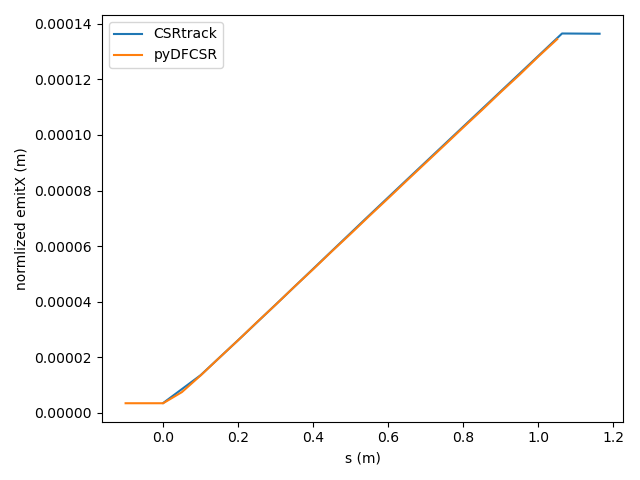

In [19]:
plt.figure()
plt.plot(CSRtrack_stats['t'], CSRtrack_stats['norm_emitX'],label = 'CSRtrack')
plt.plot(t2 - 0.1, gemitX2, label = 'pyDFCSR')
plt.ylabel('normlized emitX (m)')
plt.legend()
plt.xlabel('s (m)')
plt.tight_layout()
plt.show()

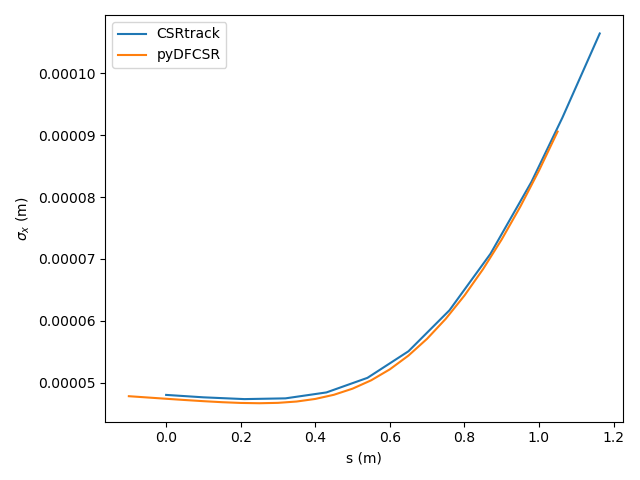

In [20]:
plt.figure()
plt.plot(CSRtrack_stats['t'], CSRtrack_stats['sigma_x'], label = 'CSRtrack')
plt.plot(t2 - 0.1, sigmaX2, label = 'pyDFCSR')
plt.xlabel('s (m)')
plt.ylabel('$\sigma_x$ (m)')
plt.tight_layout()
plt.legend()
plt.show()

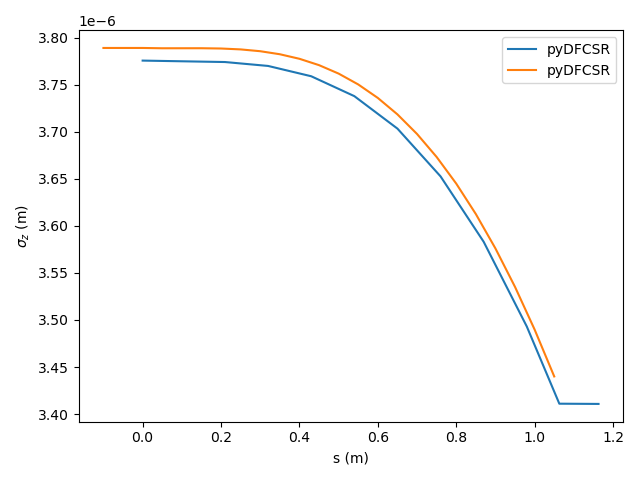

In [21]:
plt.figure()
plt.plot(CSRtrack_stats['t'], CSRtrack_stats['sigma_z'], label = 'pyDFCSR')
plt.plot(t2 - 0.1, sigmaZ2,label = 'pyDFCSR')
plt.xlabel('s (m)')
plt.ylabel('$\sigma_z$ (m)')
plt.tight_layout()
plt.legend()
plt.show()

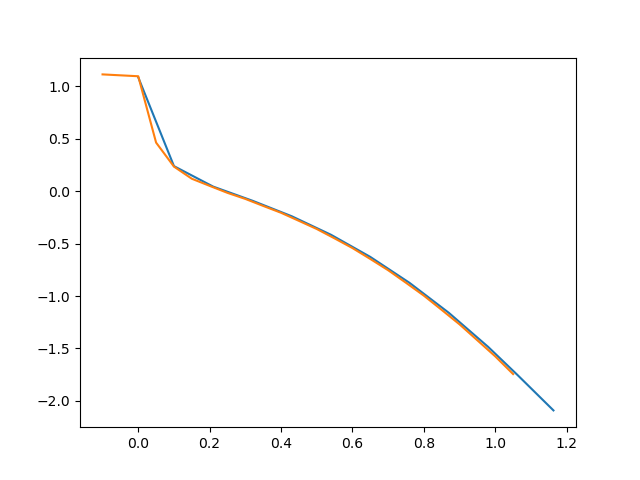

In [22]:
plt.figure()
plt.plot(CSRtrack_stats['t'], CSRtrack_stats['alphaX'])
plt.plot(t2 - 0.1, alphaX2)
plt.show()

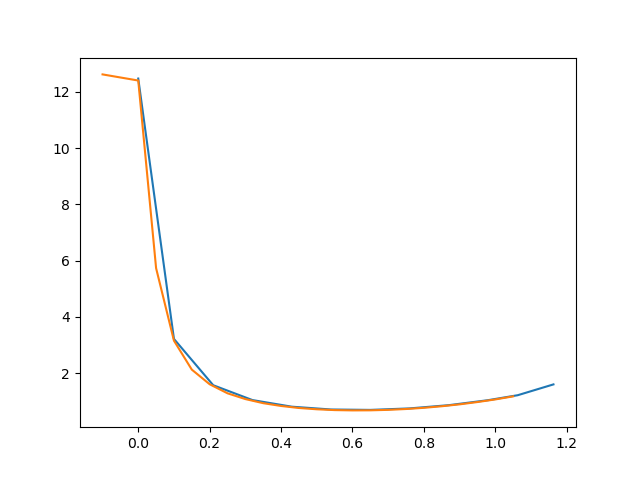

In [23]:
plt.figure()
plt.plot(CSRtrack_stats['t'], CSRtrack_stats['betaX'])
plt.plot(t2 - 0.1, betaX2)
plt.show()